In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
import torchvision.transforms as transforms

In [60]:
transform = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.1),
  transforms.RandomVerticalFlip(p=0.3),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [61]:
train_data = datasets.CIFAR10(
  root="datasets",
  train=True,
  download=True,
  transform=transform,
  target_transform=None
)
test_data = datasets.CIFAR10(
  root="datasets",
  train=False,
  download=True,
  transform=test_transform,
  target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [69]:
batch_size = 16
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [49]:
def acc(y_pred, y_true):
  if len(y_pred) != len(y_true):
    print("Error: y_pred and y_true have different lengths. Aborting")
  return torch.eq(y_pred, y_true).sum().item() / len(y_pred)

In [70]:
class FinalModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_block = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
      nn.ReLU(),
      # nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
      # nn.Dropout(p=0.25),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
      nn.ReLU(),
      # nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
      # nn.Dropout(p=0.25),
      nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
      nn.ReLU(),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      #nn.Dropout(p=0.5),
      # nn.Linear(16*5*5, 120),
      # nn.ReLU(),
      nn.Linear(120, 84),
      nn.ReLU(),
      #nn.Dropout(p=0.5),
      nn.Linear(84, 10),
    )


  def forward(self, x):
    return self.classifier(
      self.conv_block(x)
    )

model = FinalModel().to(device)
print(model)
print(next(model.parameters()).device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

FinalModel(
  (conv_block): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): ReLU()
    (3): Linear(in_features=84, out_features=10, bias=True)
  )
)
cuda:0


In [71]:
def test_model() -> tuple[float, float]:
  print("----Testing the model----")
  sum_acc = 0
  sum_loss = 0
  with torch.inference_mode():
    for i, (image, label) in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
      label = label.to(device)

      logits = model(image.to(device))
      loss = loss_fn(logits, label)
      accuracy = acc(torch.argmax(logits, dim=1), label)

      sum_loss += loss
      sum_acc += accuracy
      if i % 300 == 0:
        print(f"{i:5} | {accuracy*100:7.2f}% | {loss.item():.5f}")


    print(sum_acc / len(test_dataloader)*100, sum_loss.item() / len(test_dataloader))
  print("-------------------------")
  return sum_acc / len(test_dataloader), sum_loss.item() / len(test_dataloader)

In [73]:
model.train()
epochs = 8
train_dataloader_len = len(train_dataloader)
loss_over_time = []
val_loss_over_time = []
acc_over_time = []
val_acc_over_time = []
for epoch in tqdm(range(epochs)):
  print(f"epoch {epoch} ---")
  epoch_loss = 0
  epoch_acc = 0

  for i, (image, label) in enumerate(tqdm(train_dataloader, total=train_dataloader_len)):

    logits = model(image.to(device))

    loss = loss_fn(logits, label.to(device))

    accuracy = acc(torch.argmax(logits, dim=1), label.to(device))
    epoch_loss += loss
    epoch_acc += accuracy
    if i % 1500 == 0:
      print(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  avg_acc_val, avg_loss_val = test_model()

  val_loss_over_time.append(avg_loss_val)
  val_acc_over_time.append(avg_acc_val)
  avg_epoch_loss = epoch_loss.item() / train_dataloader_len
  loss_over_time.append(avg_epoch_loss)
  acc_over_time.append(epoch_acc / train_dataloader_len)
  print("---")
  print("epoch loss: ", avg_epoch_loss)

model.eval();

  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0 ---


  0%|          | 0/3125 [00:00<?, ?it/s]

2.297774076461792
1.5943427085876465
1.5591026544570923
----Testing the model----


  0%|          | 0/625 [00:00<?, ?it/s]

    0 |   56.25% | 1.19924
  300 |   50.00% | 1.36363
  600 |   50.00% | 1.67822
49.230000000000004 1.41648564453125
-------------------------
---
epoch loss:  1.67255578125
epoch 1 ---


  0%|          | 0/3125 [00:00<?, ?it/s]

1.685554027557373
1.7128105163574219
1.518580436706543
----Testing the model----


  0%|          | 0/625 [00:00<?, ?it/s]

    0 |   68.75% | 0.85350
  300 |   62.50% | 1.00434
  600 |   50.00% | 1.63438
51.89 1.364565234375
-------------------------
---
epoch loss:  1.39741171875
epoch 2 ---


  0%|          | 0/3125 [00:00<?, ?it/s]

1.1544269323349
1.19352388381958
1.1558444499969482
----Testing the model----


  0%|          | 0/625 [00:00<?, ?it/s]

    0 |   68.75% | 0.95753
  300 |   68.75% | 0.96007
  600 |   62.50% | 1.37852
57.69 1.18226259765625
-------------------------
---
epoch loss:  1.289133359375
epoch 3 ---


  0%|          | 0/3125 [00:00<?, ?it/s]

0.8587000966072083
1.456974983215332
0.8129163384437561
----Testing the model----


  0%|          | 0/625 [00:00<?, ?it/s]

    0 |   56.25% | 0.96211
  300 |   68.75% | 0.91876
  600 |   68.75% | 1.59678
56.84 1.21403798828125
-------------------------
---
epoch loss:  1.227464453125
epoch 4 ---


  0%|          | 0/3125 [00:00<?, ?it/s]

0.8729549646377563
1.019034743309021
0.9488365054130554
----Testing the model----


  0%|          | 0/625 [00:00<?, ?it/s]

    0 |   62.50% | 0.79694
  300 |   75.00% | 0.84708
  600 |   56.25% | 1.59410
59.089999999999996 1.15284794921875
-------------------------
---
epoch loss:  1.17827546875
epoch 5 ---


  0%|          | 0/3125 [00:00<?, ?it/s]

0.8498214483261108
0.7121556401252747
1.0052376985549927
----Testing the model----


  0%|          | 0/625 [00:00<?, ?it/s]

    0 |   75.00% | 0.67638
  300 |   75.00% | 0.96844
  600 |   56.25% | 1.40989
59.760000000000005 1.135430078125
-------------------------
---
epoch loss:  1.15061984375
epoch 6 ---


  0%|          | 0/3125 [00:00<?, ?it/s]

1.5941357612609863
0.834449052810669
0.7679822444915771
----Testing the model----


  0%|          | 0/625 [00:00<?, ?it/s]

    0 |   68.75% | 0.81564
  300 |   62.50% | 0.86558
  600 |   75.00% | 1.16295
59.69 1.14392333984375
-------------------------
---
epoch loss:  1.11933015625
epoch 7 ---


  0%|          | 0/3125 [00:00<?, ?it/s]

1.1483300924301147
0.8711618781089783
0.7330918312072754
----Testing the model----


  0%|          | 0/625 [00:00<?, ?it/s]

    0 |   87.50% | 0.72881
  300 |   62.50% | 0.92018
  600 |   62.50% | 1.18507
61.22 1.0894787109375
-------------------------
---
epoch loss:  1.105743046875


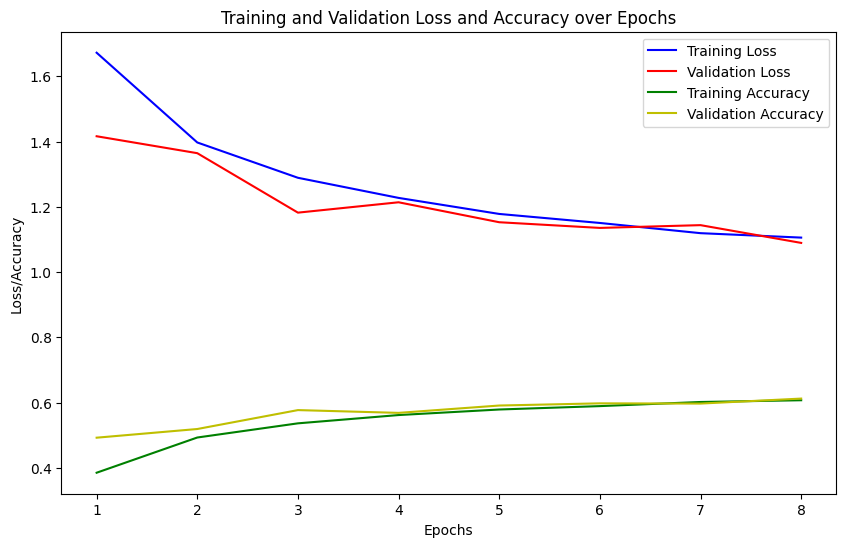

In [74]:
plt.figure(figsize=(10, 6))

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, loss_over_time, 'b-', label='Training Loss')
plt.plot(epochs_range, val_loss_over_time, 'r-', label='Validation Loss')

plt.plot(epochs_range, acc_over_time, 'g-', label='Training Accuracy')
plt.plot(epochs_range, val_acc_over_time, 'y-', label='Validation Accuracy')

plt.title('Training and Validation Loss and Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

61.22

In [76]:
torch.save(model.state_dict(), "model_weights.pth")

In [77]:
test_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [79]:
correct_pred = {classname: 0 for classname in test_data.classes}
total_pred = {classname: 0 for classname in test_data.classes}

model.eval()
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels.to(device), predictions):
            if label == prediction:
                correct_pred[test_data.classes[label]] += 1
            total_pred[test_data.classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 56.0 %
Accuracy for class: automobile is 79.0 %
Accuracy for class: bird  is 53.3 %
Accuracy for class: cat   is 27.4 %
Accuracy for class: deer  is 50.4 %
Accuracy for class: dog   is 62.5 %
Accuracy for class: frog  is 72.1 %
Accuracy for class: horse is 65.4 %
Accuracy for class: ship  is 74.1 %
Accuracy for class: truck is 72.0 %


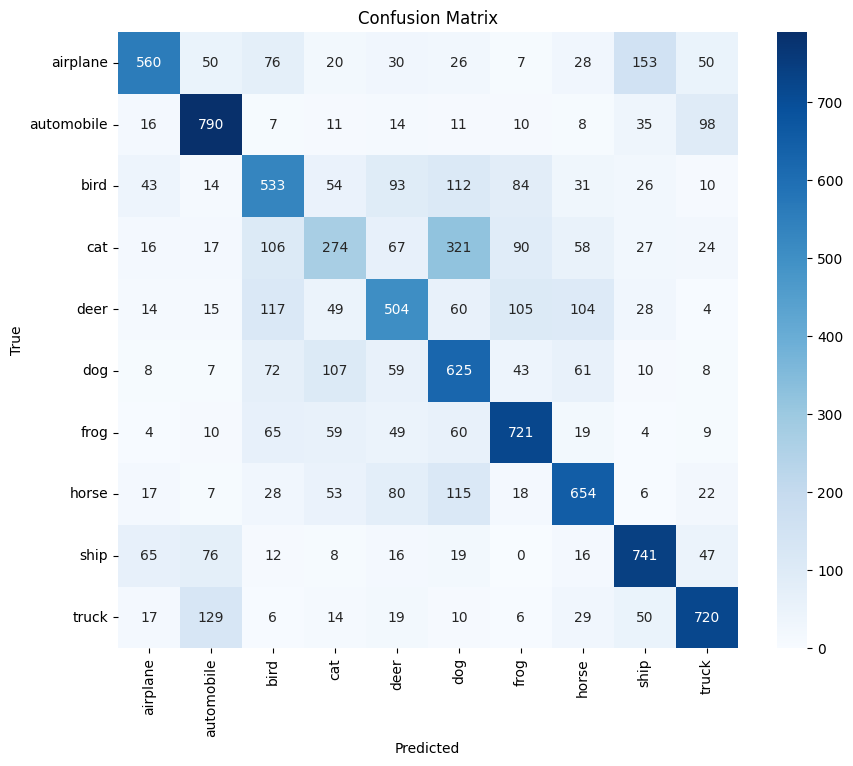

In [81]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predictions = torch.max(outputs, 1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [83]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

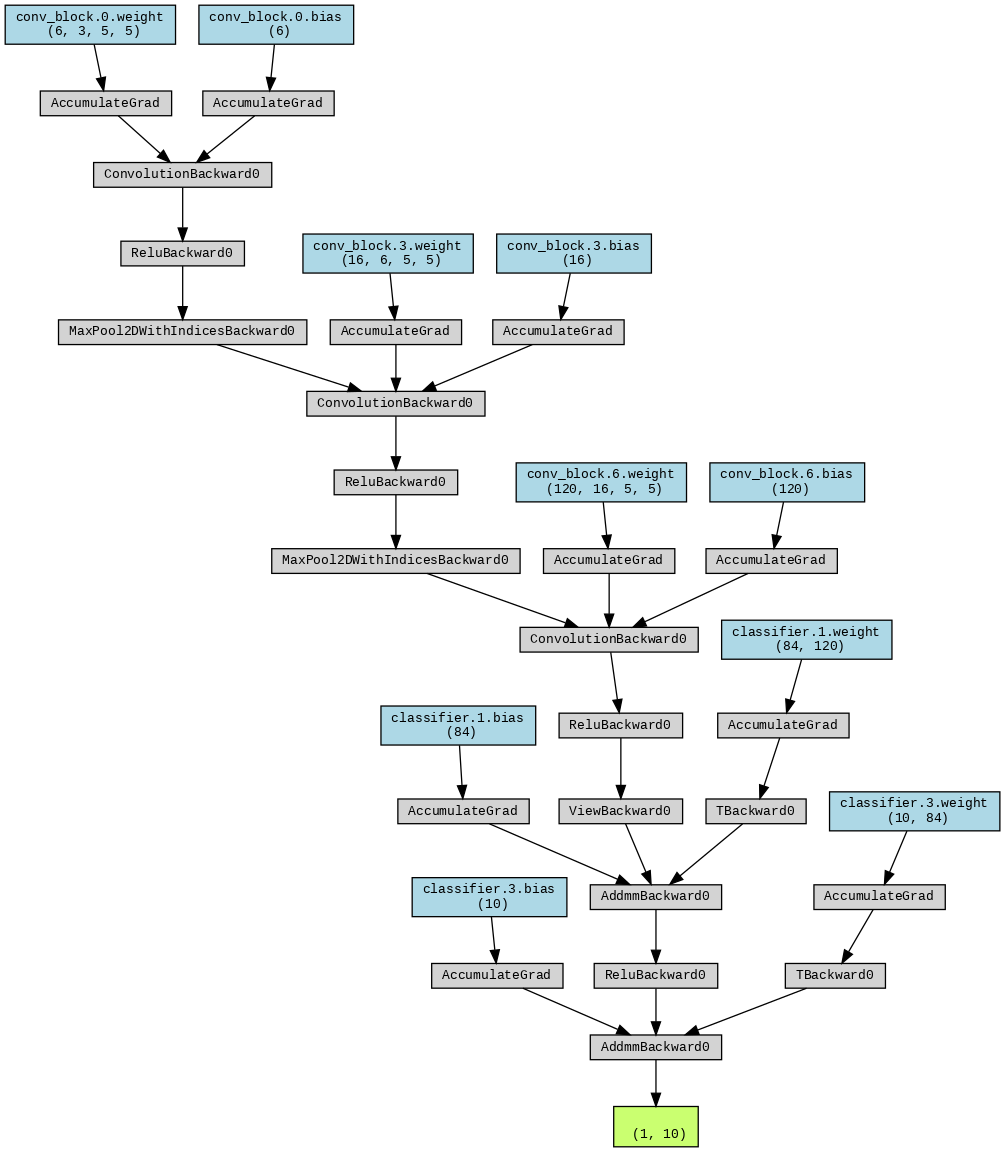

In [85]:
from torchviz import make_dot
from IPython.display import Image

dummy_input = torch.randn(1, 3, 32, 32).to(device)

viz = make_dot(model(dummy_input), params=dict(model.named_parameters()))

viz.render("model_architecture", format="png")

Image("model_architecture.png")

In [86]:
!pip install netron

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.5 MB/s eta 0:00:00


In [90]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 22.1 MB/s eta 0:00:00


In [88]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 14.8 MB/s eta 0:00:00


In [91]:
dummy_input = torch.randn(1, 3, 32, 32).to(device)
torch.onnx.export(model, dummy_input, "model.onnx")

In [ ]:
import netron
netron.start("model.onnx")

In [96]:
!pip install torchview

In [97]:
!pip install graphviz

In [99]:
!pip install torchview

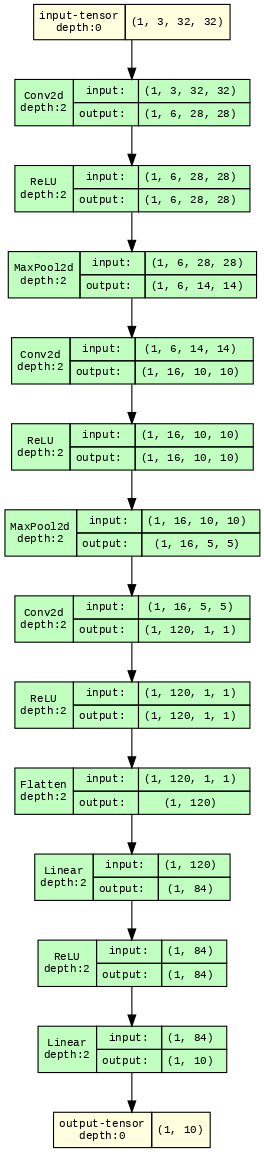

In [103]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')
model_graph = draw_graph(model, input_size=(1, 3, 32, 32), device='meta')
model_graph.visual_graph